
# example0 — Single NMC run: φ(z), R(y,x) and Rd

This notebook runs a single Monte Carlo simulation using the NMC model for a homogeneous slab and inspects both the **fluence** and the **diffuse reflectance**.

**Workflow**

1. Set up grid, beam, flags, and homogeneous optical properties.  
2. Write the NMC input files `test_H.mci` and `test_T.bin`.  
3. (Optional) Run the external NMC binary: `./nmc test` (if present in the working directory).  
4. Load the outputs `test_Rd.dat`, `test_Ryx.dat`, and `test_F.bin` (if available).  
5. Plot the spatial reflectance map R(y,x), a fluence slice F(z,x), and the on-axis semilog fluence φ(z) at x=0, y=0.  
6. Compute the Farrell diffusion-theory diffuse reflectance `R_d` for comparison.  
7. Fit φ(z) with a single-exponential model `a · exp(−b z)` over a chosen depth range and compare to theory.

> If the NMC binary is not found, the notebook skips the MC run and only works with theory-based quantities or previously generated output files.

In [10]:

# === Imports and helper: Farrell diffuse reflectance ===
import os, math, subprocess
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

nmcdir  = Path('../NMC/DerivedData/NMC/Build/Products/Release')
# Use nmcdir if it exists; otherwise stay in current dir to avoid errors.
if nmcdir.exists():
    os.chdir(nmcdir)
print('Working directory:', Path.cwd())

def get_rd_farrell(mua, musp, n_ratio):
    """Vectorized Farrell diffuse reflectance (Farrell et al., Med. Phys. 19:879–888, 1992).
    Parameters
    ----------
    mua : float
        Absorption coefficient (e.g., mm^-1)
    musp : float
        Reduced scattering coefficient (e.g., mm^-1)
    n_ratio : float
        Index ratio n_tissue / n_outside (scalar)
    Returns
    -------
    float
        Diffuse reflectance Rd
    """
    ri = 0.6681 + 0.0636*n_ratio + 0.7099/n_ratio - 1.4399/(n_ratio**2)
    A = (1.0 + ri) / (1.0 - ri)
    zo = 1.0 / (mua + musp)
    D = zo / 3.0
    delta = np.sqrt(D / mua)
    mueff = 1.0 / delta
    ap = musp / (mua + musp)
    Rd = ap * np.exp(-mueff * zo) / 2.0 * (1.0 + np.exp(-(4.0/3.0) * A * np.sqrt(3.0 * (1.0 - ap))))
    return float(Rd)


Working directory: /Users/aledoronin/Desktop/NMC_framework/NMC/DerivedData/NMC/Build/Products/Release


In [2]:
# === 1.a) Simulation parameters ===
myname = 'test'

# Grid and voxel size
NBINS   = 200
binsize = 0.02  # [mm]
dx = dy = dz = binsize
Nx = Ny = Nz = NBINS

x = (np.arange(1, Nx+1) - Nx/2.0) * dx
y = (np.arange(1, Ny+1) - Ny/2.0) * dy
z = (np.arange(1, Nz+1)) * dz

na = 90.0  # numerical aperture (deg ~ 90 collects all reflectance)

# Launch flags
mcflag       = 0  # 0 uniform beam
launchflag   = 0  # 0 MC kernel computes launch trajectory
boundaryflag = 2  # 2 escape at surface only
mckernelflag = 1  # 1=mcxyz
speckleflag  = 0
semiflag     = 1

zsurf = 0.0

# Source and focus
xs=0.0; ys=0.0; zs=0.0
xfocus=0.0; yfocus=0.0; zfocus=1e12  # inf -> large number

# Beam geometry
radius=1.2; det_radius=5.0; separation=0.0; waist=radius

# Optional manual launch (used if launchflag==1)
ux0=0.7; uy0=0.4; uz0=math.sqrt(1-ux0**2-uy0**2)

# Aux / ignored for MC here
time_min=1.0; lambda_mm=640.0e-6; lc=0.001; det_state=0

# Optical properties (single homogeneous layer)
mua=1.0      # [1/mm]
mus=100.0    # [1/mm]
g=0.90
n1=1.4
n2=1.001

# Two-term placeholders (ignored when CC==1)
CC=1; gf=g; af=0.5; gb=0.9; ab=0.5
Nt=1
muav=[mua]; musv=[mus]; gv=[gf]; afv=[af]; gbv=[gb]; abv=[ab]; CCv=[CC]

print('Grid:', Nx, Ny, Nz, 'binsize=', binsize, 'mm')


Grid: 200 200 200 binsize= 0.02 mm


In [3]:
# === 2) Write input: test_H.mci ===
filename = f'{myname}_H.mci'
with open(filename, 'w') as fid:
    # run parameters
    fid.write(f"{time_min:.2f}\n")
    fid.write(f"{Nx}\n{Ny}\n{Nz}\n")
    fid.write(f"{dx:.4f}\n{dy:.4f}\n{dz:.4f}\n")
    # launch parameters
    fid.write(f"{mcflag}\n{launchflag}\n{boundaryflag}\n")
    fid.write(f"{xs:.4f}\n{ys:.4f}\n{zs:.4f}\n")
    fid.write(f"{xfocus:.4f}\n{yfocus:.4f}\n{zfocus:.4f}\n")
    fid.write(f"{ux0:.4f}\n{uy0:.4f}\n{uz0:.4f}\n")
    fid.write(f"{radius:.4f}\n{waist:.4f}\n{zsurf:.4f}\n")
    fid.write(f"{det_radius:.4f}\n{separation:.4f}\n")
    fid.write(f"{n1:.4f}\n{n2:.4f}\n")     # NEW in your MATLAB comments
    fid.write(f"{na:.4f}\n{lambda_mm:.4f}\n{lc:.4f}\n")
    fid.write(f"{speckleflag}\n{semiflag}\n{det_state}\n{mckernelflag}\n")
    # tissue optical properties
    fid.write(f"{Nt}\n")
    for i in range(Nt):
        fid.write(f"{muav[i]:.4f}\n{musv[i]:.4f}\n")
        if mckernelflag < 2:
            fid.write(f"{gv[i]:.4f}\n")
        else:
            fid.write(f"{gfv[i]:.4f}\n{afv[i]:.4f}\n{gbv[i]:.4f}\n{abv[i]:.4f}\n{CCv[i]:.4f}\n")
print('Wrote', filename)


Wrote test_H.mci


In [4]:

# === 3) Create homogeneous T(y,x,z) and write test_T.bin ===
T = np.zeros((Ny, Nx, Nz), dtype=np.uint8)
T[:] = 1  # homogeneous background of type 1
filename = f'{myname}_T.bin'
with open(filename, 'wb') as f:
    f.write(T.ravel(order='C'))  # same linearization style
print('Wrote', filename, 'bytes =', Path(filename).stat().st_size)


Wrote test_T.bin bytes = 8000000


In [5]:

# === 4) Optional Monte Carlo run (if ./nmc present) ===
if Path('./nmc').exists():
    ret = subprocess.run(['./nmc', myname], capture_output=True, text=True)
    print('nmc return code:', ret.returncode)
    if ret.stdout: print(ret.stdout)
    if ret.stderr: print('stderr:', ret.stderr)
else:
    print('No ./nmc binary found; skipping MC run.')


nmc return code: 0
name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 0 [mm]
launching uniform flat-field beam
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.2000 [mm]
waist  = 1.2000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 2, so escape at surface only.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 1.0000 [mm^-1]
musv[1] = 100.0000 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.4000 [mm]
n2 = 1.0010 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):7.094098
Simulation rate 14096 [photons/sec]
saving test_F.bin
------

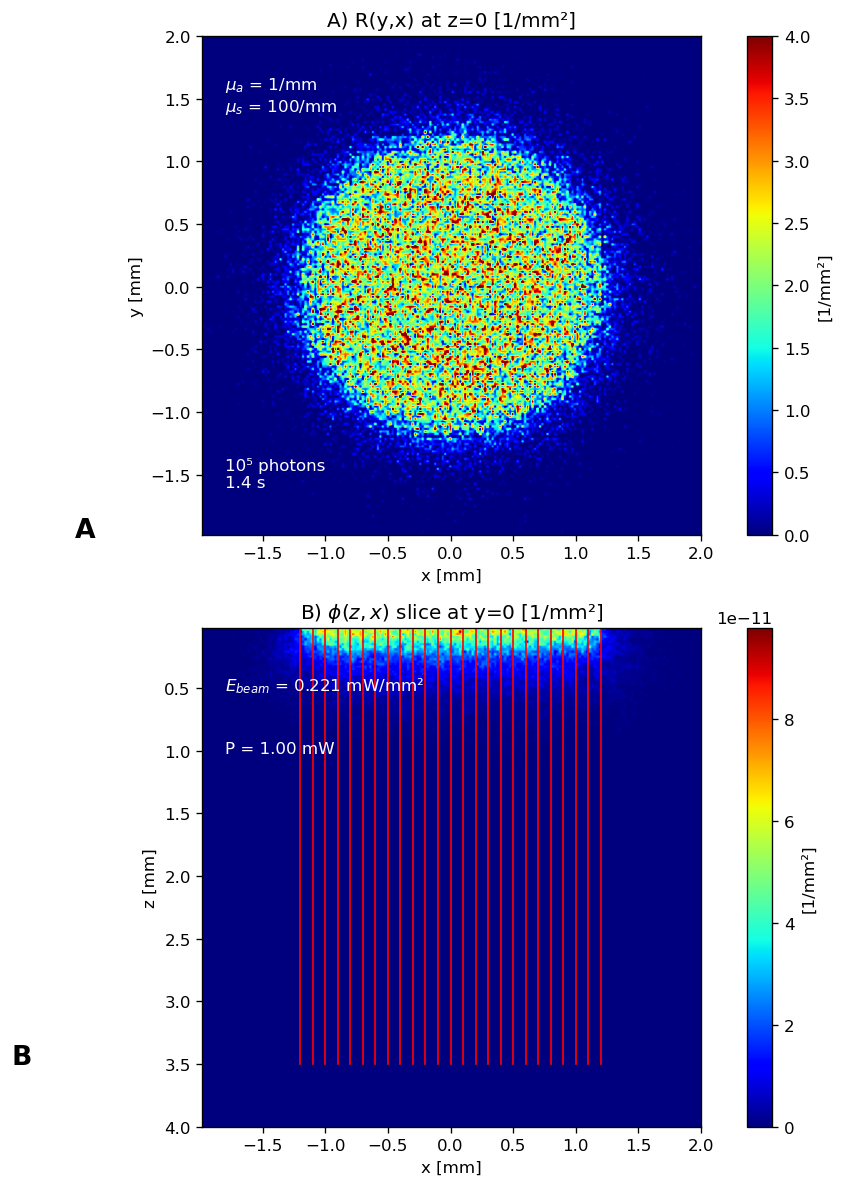

In [6]:
# === 5) Load outputs (if present) and reproduce plots A & B ===
# === Paths ===
Rd_path   = Path(f'{myname}_Rd.dat')
Ryx_path  = Path(f'{myname}_Ryx.dat')
Fbin_path = Path(f'{myname}_F.bin')

# === Load Data ===
have_Ryx = Ryx_path.exists()
have_F   = Fbin_path.exists()

if have_Ryx:
    Ryx = np.loadtxt(Ryx_path)
else:
    Ryx = None
    print('Missing', Ryx_path.name)

if have_F:
    NxNyNz = Nx * Ny * Nz
    with open(Fbin_path, 'rb') as fid:
        Fyxz = np.fromfile(fid, dtype=np.float32, count=NxNyNz)
    Fyxz = Fyxz.reshape(Ny, Nx, Nz) / 1e5 * dx * dy * dz  # Normalize
else:
    Fyxz = None
    print('Missing', Fbin_path.name)

# === Plot A & B ===
if (Ryx is not None) and (Fyxz is not None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), dpi=120)

    # === Panel A: Reflectance R(y,x)
    im1 = ax1.imshow(Ryx, extent=[x.min(), x.max(), y.min(), y.max()],
                     origin='lower', aspect='equal', cmap='jet', vmin=0, vmax=4)
    plt.colorbar(im1, ax=ax1, label='[1/mm²]')
    ax1.set_title('A) R(y,x) at z=0 [1/mm²]', fontsize=12)
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    ax1.text(-1.8, -1.6, '10⁵ photons\n1.4 s', color='white')
    ax1.text(-1.8,  1.4, f'$\\mu_a$ = {mua:.0f}/mm\n$\\mu_s$ = {mus:.0f}/mm', color='white')
    ax1.text(-3.0, -2.0, 'A', fontsize=16, fontweight='bold')

    # === Panel B: Fluence ϕ(z,x) slice at y = 0 (corrected with flipped Z axis) ===
    Fzx = Fyxz[:, :, Nz // 2]  # Correct Z-X slice at y = 0

    im2 = ax2.imshow(Fzx,
                 extent=[x.min(), x.max(), z.max(), z.min()],  # Reverse z-axis
                 aspect='equal', cmap='jet')
    plt.colorbar(im2, ax=ax2, label='[1/mm²]')
    ax2.set_title('B) $\\phi(z,x)$ slice at y=0 [1/mm²]', fontsize=12)
    ax2.set_xlabel('x [mm]')
    ax2.set_ylabel('z [mm]')

    # Add red beam lines only in the white region
    z_line_top = z.min()
    z_line_bottom = z.max() - 0.5  # length of lines (adjust as needed)
    for i in np.arange(-radius, radius + 0.001, 0.1):
        ax2.plot([i, i], [z_line_bottom, z_line_top], 'r-', linewidth=1)

    # Beam energy annotations (adjusted for flip)
    E_beam = 1 / (np.pi * radius**2)
    ax2.text(-1.8, z.min() + 0.5, f'$E_{{beam}}$ = {E_beam:.3f} mW/mm²', color='white')
    ax2.text(-1.8, z.min() + 1.0, 'P = 1.00 mW', color='white')
    ax2.text(-3.5, z.max() - 0.5, 'B', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print('Not enough MC outputs to draw A & B.')

In [7]:

# === 6) Farrell diffuse reflectance (theory) ===
musp = mus * (1 - g)         # reduced scattering coefficient
n_ratio = n1 / n2
Rdt = get_rd_farrell(mua, musp, n_ratio)
print('R_diffusion.theory (Farrell):', Rdt)

# Also print MC Rd if available
if Path(f'{myname}_Rd.dat').exists():
    rd_mc = np.loadtxt(f'{myname}_Rd.dat')
    print('Rd (MC):', rd_mc)


R_diffusion.theory (Farrell): 0.2978437731984608
Rd (MC): 0.266


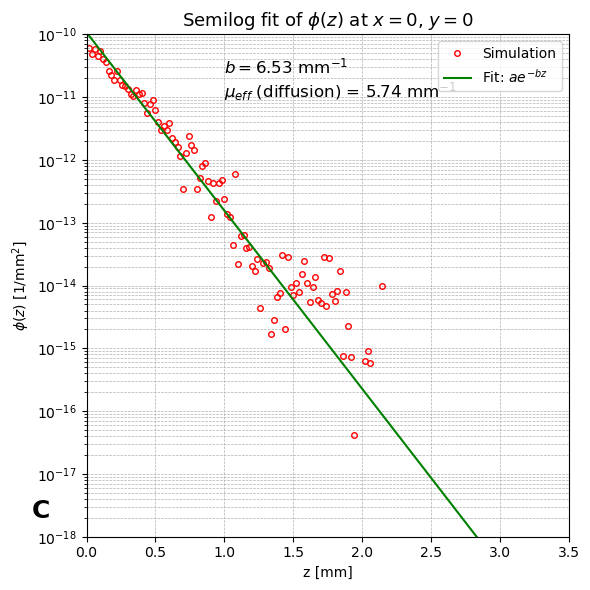

a = 1.070999e-10, b = 6.533278 1/mm
mueff (diffusion) = 5.744563 1/mm


In [8]:
# Minimal threshold to avoid log(0)
eps = 1e-18  

# Extract central axial profile
Fz = np.squeeze(Fyxz[:, Ny // 2, Nz // 2])

# --- Plotting setup ---
plt.figure(figsize=(6, 6))
plt.semilogy(z, Fz, 'ro', markerfacecolor='none', linewidth=1, markersize=4, label='Simulation')

# --- Fit range selection ---
z_min = 0.0 / musp      # Ignore early ballistic range
z_max = 1.3             # Ignore deep noise

# Fit range indices
i1 = np.searchsorted(z, z_min, side='right')
i2 = np.searchsorted(z, z_max, side='right') if np.any(z > z_max) else len(z) - 1
fit_slice = slice(i1, i2 + 1)

# Filter valid values for log fitting
z_fit = z[fit_slice]
Fz_fit = Fz[fit_slice]
valid = Fz_fit > 0
z_fit, Fz_fit = z_fit[valid], Fz_fit[valid]

# --- Exponential fit ---
fit = np.polyfit(z_fit, np.log(Fz_fit), 1)
b = -fit[0]
a = np.exp(fit[1])

# Fitted curve
zz = np.linspace(0, 3.5, 200)
yy = a * np.exp(-b * zz)
plt.semilogy(zz, yy, 'g-', linewidth=1.5, label=rf'Fit: $ae^{{-bz}}$')

# --- Diffusion theory calculation ---
D = 1.0 / (3.0 * (mua + musp))
mueff = np.sqrt(mua / D)

# --- Annotation ---
plt.text(1.0, 1e-11,
         rf'$b = {b:.2f}$ mm$^{{-1}}$' + '\n' +
         rf'$\mu_{{eff}}$ (diffusion) = {mueff:.2f} mm$^{{-1}}$', fontsize=12)

# --- Final styling ---
plt.xlabel('z [mm]')
plt.ylabel(r'$\phi(z)$ [1/mm$^2$]')
plt.title(r'Semilog fit of $\phi(z)$ at $x = 0$, $y = 0$', fontsize=13)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.axis('tight')
plt.xlim([0, 3.5])
plt.ylim([1e-18, 1e-10])
plt.text(-0.4, 2e-18, 'C', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Print output ---
print(f"a = {a:.6e}, b = {b:.6f} 1/mm")
print(f"mueff (diffusion) = {mueff:.6f} 1/mm")
